In [44]:
import my_lib as my
import matplotlib.pyplot as plt
import numpy as np
import scipy as s
import pandas as pd
from scipy import stats
from math import log10, floor,pi,sqrt,tan

m=0.001
u=0.000001
n=0.000000001
p=0.000000000001
k=1000
M=1000000
G=1000000000
T=1000000000000

In [45]:
#funzioni
#Pt 1
def Lambda(x,Z,F,m): # nm
    L = x*F/(Z*m) *M  # M: normalizzazione L[nm]
    return L

#Pt 2
def Beta(x,Z,d,L):
    B = pi*d*x/(L*Z) *M
    return B
def Intensity(B,I0):
    I = I0*np.power(np.sin(B)/B,2)
    return I

In [46]:
#errore
#Pt 1

def SigmaLambda(x,sx,Z,sZ,F,sF):
    dx = Lambda(sx,Z, F,m) 
    dF = Lambda( x,Z,sF,m) 
    dZ = F*x/np.power(Z,2)*sZ *M
    sL = np.sqrt(np.power(dx,2) + np.power(dZ,2) + np.power(dF,2) )
    return sL


#Pt 2
def SigmaBeta(x,sx,Z,sZ,d,sd,L,sL):
    dx = Beta(sx,Z, d,L)
    dd = Beta( x,Z,sd,L)
    dZ = pi*d*x/(L*np.power(Z,2))*sZ *M
    dL = pi*d*x/(Z*np.power(L,2))*sL *M
    sB = np.sqrt(np.power(dx,2) + np.power(dZ,2) + np.power(dd,2) + np.power(dL,2) ) 
    return sB

def SigmaIntensity(B,sB,I0,sI0):
    dB = 2*I0*np.sin(B)*( B*np.cos(B)-np.sin(B) )/np.power(B,3)*sB
    dI0 = Intensity(B,sI0)
    sI = np.sqrt( np.power(dB,2) + np.power(dI0,2) )
    return sI

In [47]:
# Parte 1
Z = 852     # mm 
sZ  = 2

In [48]:
# Lettura 1
df1   = pd.read_csv('data1.csv')
m     = np.asarray(df1.iloc[:,0]) # m del minimo
F     = np.asarray(df1.iloc[:,1]) #fenditura

sF    = np.full(7,0.001) # sigma a caso
# sigma a caso
df1

,m,d[mm],I0[mV],I1[mV],I2[mV],I3[mV],I4[mV],x0[mm],x1[mm],x2[mm],x3[mm],x4[mm]
0,1.00,0.2,6400,55,47,55,57,10.90,8.39,8.34,7.13,7.00
1,1.00,0.2,6400,31,27,24,28,10.90,13.67,13.84,14.40,14.42
2,1.00,0.4,7280,70,68,72,78,8.28,6.98,7.00,7.07,7.09
3,1.00,0.4,7280,165,154,152,158,8.28,10.41,10.44,10.53,10.54
4,1.22,0.6,8020,71,68,76,82,10.84,9.09,9.01,9.00,8.98
5,1.22,0.4,8850,46,44,42,45,8.74,7.09,7.06,6.99,6.97
6,1.22,0.4,8850,122,121,124,128,8.74,10.16,10.15,10.10,10.07


In [49]:
ArrX = np.asarray(df1.iloc[:,8:12])
ArrY = np.asarray(df1.iloc[:,3:7])
ArrsX = ArrX*0.02 #non comta
ArrsY = ArrY*0.05

Xmin = np.asarray([])
sXmin = np.asarray([])

for x in range(len(ArrX)):
    X  = ArrX[x]
    sX = ArrsX[x]
    Y  = ArrY[x]
    sY = ArrsY[x]
    
    m1,sm1,q1,sq1 = my.Retta(X[0],sX[0],X[1],sX[1],Y[0],sY[0],Y[1],sY[1])
    m2,sm2,q2,sq2 = my.Retta(X[2],sX[2],X[3],sX[3],Y[2],sY[2],Y[3],sY[3])


    Value = (q2-q1)/(m1-m2)
    sValue = my.SigmaM(m2,sm2,m1,sm1,q1,sq1,q2,sq2)      
    Xmin = np.append(Xmin,Value)                         
    sXmin = np.append(sXmin,sValue)

Xmin =  np.abs(Xmin  - df1.iloc[:,7])


#x = np.linspace(np.min(X)*1.1,np.max(X)*1.1,100)
#plt.errorbar(X,Y,yerr=0.01,ls='',color='g',marker='.')
#plt.plot(x,m1*x+q1)
#plt.plot(x,m2*x+q2)
#plt.vlines(tuamadre, ymin=0, ymax = 100)
#plt.ylim(0,np.max(Y)*1.1)

#Xmin[2] = Xmin[2]+0.5
Xmin[1] = Xmin[1]-0.5
Xmin[3] = Xmin[3]-0.5
Xmin[4] = Xmin[4]-0.5

print(Xmin)
print(sXmin)


0    2.620526
1    2.954474
2    1.237500
3    1.717931
4    1.315185
5    1.737692
6    1.394286
Name:  x0[mm], dtype: float64
[ 3.66096108  5.98929733  6.34330692 12.61682962  7.6259584   6.04825038
 39.53360085]


In [50]:
Array_L  = Lambda(Xmin,Z,F,m)
Array_sL = SigmaLambda(Xmin,sXmin,Z,sZ,F,sF)
L = np.sum(Array_L)/len(Array_L)
sL = my.sqrt_sum(Array_sL)/len(Array_sL)
#sL = 1
print(Array_L)
print('Lambda =',L,' +- ',sL)

0    615.147022
1    693.538424
2    580.985915
3    806.540392
4    759.169467
5    668.703266
6    536.552649
Name:  x0[mm], dtype: float64
Lambda = 665.8053051546856  +-  2486.344657072724


In [51]:
# Parte 2 
L = 660
sL = 50
d = 0.4  # mm 
sd  = 0.001*d

#Parametri ricavati da fit 
x_offset = 6.0006
I0 = 7065.942      # misurata nel massimo
sI0 = 0.05*I0

In [52]:
# Lettura 2
df2 = pd.read_csv('data2.csv')
xmis  = np.asarray(df2.iloc[:,0]) - x_offset
Imis  = np.asarray(df2.iloc[:,1])

sxmis = np.full(41,0.0) # sigma a caso
sImis = Imis*0.05

In [53]:
# Array per andamento Teorico
x = np.linspace(-6,6,1000) #mm
sx = np.zeros(1000)
print('Z = ',Z,' mm')
print('d = ',d,' mm')
print('L = ',L,' nm')

Z =  852  mm
d =  0.4  mm
L =  660  nm


In [54]:
B  = Beta(x,Z,d,L)
sB = SigmaBeta(x,sx,Z,sZ,d,sd,L,sL)

I  = Intensity(B,I0) 
sI = SigmaIntensity(B,sB,I0,sI0)

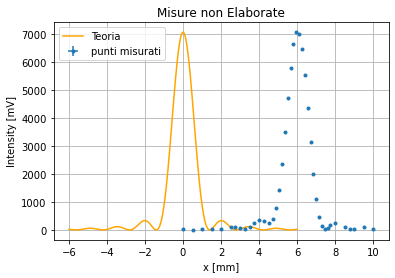

In [55]:
#Grafico intensità

plt.plot(x,I,color='orange',label='Teoria') #Teoria
plt.errorbar(xmis + x_offset,Imis, yerr=0, xerr=0, ls='', marker='.', label='punti misurati') #Misurati


plt.title('Misure non Elaborate')
plt.xlabel('x [mm]')
plt.ylabel('Intensity [mV]')
plt.grid()
plt.legend()

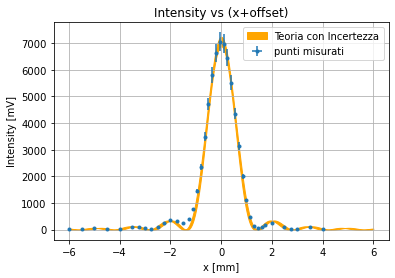

In [56]:
#Teorico Incertezza

plt.errorbar(xmis,Imis, yerr=sImis, xerr=0, ls='', marker='.', label='punti misurati')

#plt.plot(x,I+sI/2, ls='--',color = 'orange', label = 'Banda Incertezza')
#plt.plot(x,I-sI/2, ls='--',color = 'orange')
plt.fill_between(x,I+sI/2,y2 = I-sI/2, color = 'orange',label = 'Teoria con Incertezza')


#plt.ylim(0,1000)
plt.title('Intensity vs (x+offset)')
plt.xlabel('x [mm]')
plt.ylabel('Intensity [mV]')
plt.grid()
plt.legend()

In [57]:
#Chi quadro

Xdata  = xmis
sXdata = sxmis

Ydata = Imis
sYdata = sImis

Yexp  = Intensity(Beta(Xdata,Z,d,L),I0)
sYexp = SigmaIntensity( Beta(Xdata,Z,d,L), SigmaBeta(Xdata,sXdata,Z,sZ,d,sd,L,sL), I0,sI0)

#Yerror = sImis
Yerror = np.sqrt( np.power(sYdata,2) + np.power(sYexp,2) ) # Sta cosa non so troppo convinto che è giusta ma stica

chi2 = np.sum( ( (Yexp - Ydata)/Yerror )**2 )
print('chi2 = ',chi2)

chi2 =  41.75756831144443


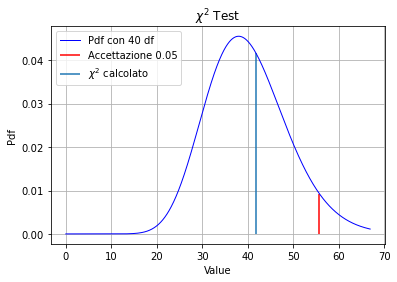

0

In [58]:
#Grafico del fit
my.chi_graph(chi2,r'$\chi^2$ calcolato',40)

In [61]:
#Lettura 2
df3 = pd.read_csv('data3.csv')
xmis  = np.asarray(df3.iloc[:,0])
Imis  = np.asarray(df3.iloc[:,1])

<ErrorbarContainer object of 3 artists>

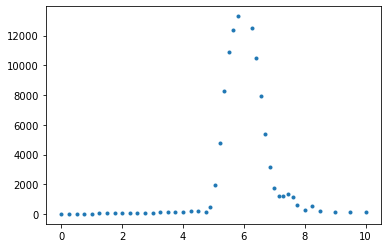

In [62]:
plt.errorbar(xmis,Imis, yerr=0, xerr=0, ls='', marker='.', label='punti misurati')